In [49]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# The setup

The purpose is to fit a *logistic*, an *exponential* and a *Generalized Richards Model (GRM)* to the daily number of registered Hungarian Covid-19 cases.

These functions have the following forms:

Logistic $$f_{logit}(x) = \frac{a}{1 + b * e^{-c * x}} + d$$

Exponential $$f_{exp}(x) = z * e^{v * x} + w$$

where $x$ is the number of days since he first registered patient, $a, b, c, z, v$ are parameters to estimate, $d$ and $w$ are initial number of patients. Given the number of cases was initially zero $d=w=0$.

Logistic

In [913]:
def f_logit(x, a, b, c):
    return a / (1. + b * np.exp(-c * x))

Exponential

In [914]:
def f_exp(x, z, v):
    return z * np.exp(v * x)

Generalized Richards Model (GRM)

For more details see Ke Wu et al. 
https://arxiv.org/ftp/arxiv/papers/2003/2003.05681.pdf

In [810]:
#The dynamics
def velocity_GRM(Ct, K, r, p, alpha):
    return r*(Ct**p)*(1-(Ct/K)**alpha)

def f_GRM(x, C0, K, r, p, alpha):
    evolution = [C0]
    for n in range(0,x):
        if n>0:
            evolution.append(velocity_GRM(np.cumsum(evolution)[n-1], K, r, p, alpha))
            #print(np.cumsum(evolution)[n-1])
    return sum(evolution)   

In [811]:
f_GRM(5, C0, K, r, p, alpha)

2.0
9.532570385794736
29.589823628586785
69.71817959938596


134.4151164541319

# Data

Because I did not find official sources I scraped the Hunarian wikipedia page:
https://hu.wikipedia.org/wiki/2020-as_COVID-19_koronav%C3%ADrus-j%C3%A1rv%C3%A1ny_Magyarorsz%C3%A1gon

In [706]:
import requests
import lxml.html as lh

url='https://hu.wikipedia.org/wiki/2020-as_COVID-19_koronav%C3%ADrus-j%C3%A1rv%C3%A1ny_Magyarorsz%C3%A1gon'

#Create a handle, page, to handle the contents of the website
page = requests.get(url)

#Store the contents of the website under doc
doc = lh.fromstring(page.content)

#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

Sanity check

In [717]:
#For sanity check see the length of the first 12 rows
[len(T) for T in tr_elements[:12]]

[2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

Processing the header

In [718]:
#At the time of the implementation the first 3 rows contain a disclaimer
table_starts_at = 2

#Create empty list
col=[]
i=0

#For each row, store each first element (header) and an empty list
for t in tr_elements[table_starts_at]:
    i+=1
    name=t.text_content()
    col.append((name,[]))

Processing the body

In [719]:
#Since out first row is the header, data is stored on the second row onwards
for j in range(table_starts_at+1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 6, the //tr data is not from our table 
    if len(T)!=6:
        print('Length of row {} is different from 6 cells'.format(j-table_starts_at))
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1

Sanity check

In [720]:
#Check the length of each column
[len(C) for (title,C) in col]

[19, 19, 19, 19, 19, 19]

Dataframe

In [721]:
col

[('Dátum[135]\n',
  ['2020‑03‑04',
   '2020-03-05',
   '2020-03-06',
   '2020-03-07',
   '2020-03-08',
   '2020-03-09',
   '2020-03-10',
   '2020-03-11',
   '2020-03-12',
   '2020-03-13',
   '2020-03-14',
   '2020-03-15',
   '2020-03-16',
   '2020-03-17',
   '2020-03-18',
   '2020-03-19',
   '2020-03-20',
   '2020-03-21',
   '2020-03-22']),
 ('Regisztrált fertőzött\n',
  [2, 4, 4, 5, 7, 9, 12, 13, 15, 18, 29, 30, 36, 47, 55, 70, 74, 92, 113]),
 ('Elhunyt\n', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 4, 4, 6]),
 ('Gyógyult\n', [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 7, 7, 12]),
 ('Összesen\n',
  [2, 4, 4, 5, 7, 9, 12, 13, 16, 19, 30, 32, 39, 50, 58, 73, 85, 103, 131]),
 ('Megjegyzés\n',
  ['Orbán Viktor miniszterelnök rendkívüli bejelentése: két koronavírussal fertőzött beteg van Magyarországon.[136]\n',
   '\n',
   '39 ember karanténban, és 269 mintavétel történt.[137]\n',
   '\n',
   'A koronavírus által fertőzött hét beteg közül 4 iráni, 1 brit, és 2 magyar állampolgá

In [724]:
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)

# English header
df.columns = ['Date', 'Sick','Died','Recovered','Total','Note']


# Store the number of days since onset
df.reset_index(inplace=True)
df.set_index('Date',inplace=True)

df.rename(columns={ df.columns[0]: "Day" }, inplace = True)

(array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.]),
 <a list of 10 Text xticklabel objects>)

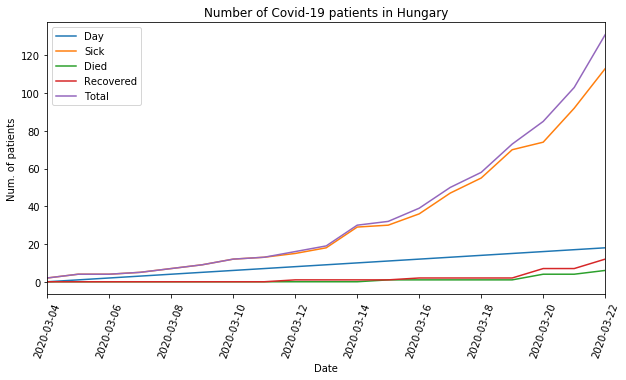

In [725]:
df.plot(figsize=(10,5))
plt.xlabel('Date')
plt.ylabel('Num. of patients')
plt.title('Number of Covid-19 patients in Hungary')
degrees = 70
plt.xticks(rotation=degrees)

# Curve fitting

Exponential

In [916]:
parameters_exp, pcov_exp  = opt.curve_fit(f_exp, df['Day'].to_numpy()+1, df['Total'].to_numpy())
perr = np.sqrt(np.diag(pcov))

extrapol_horizon = 3
long_extrapol_horizon = 14

fitting_horizon = np.array(range(1,np.max(df['Day'].to_numpy()+2)+extrapol_horizon))
long_fitting_horizon = np.array(range(1,np.max(df['Day'].to_numpy()+2)+long_extrapol_horizon))

y_fit_exp = f_exp(fitting_horizon, *parameters_exp)
long_y_fit_exp = f_exp(long_fitting_horizon, *parameters_exp)

#Fit a version on older data to see the changes of predictions
parameters_exp_old, perr_old  = opt.curve_fit(f_exp, df['Day'].to_numpy()[:-5]+1, df['Total'].to_numpy()[:-5])
long_y_fit_exp_old = f_exp(long_fitting_horizon, *parameters_exp_old)

#Dates
times = pd.date_range('2020-03-04', periods=len(df['Day'])+extrapol_horizon, freq='D')
long_times = pd.date_range('2020-03-04', periods=len(df['Day'])+long_extrapol_horizon, freq='D')

Confidece intervals

In [917]:
# prepare confidence level curves
nstd = 1. # to draw 1-sigma intervals
parameters_exp_up = parameters_exp + nstd * perr
parameters_exp_dw = parameters_exp - nstd * perr

fit_up = f_exp(fitting_horizon, *parameters_exp_up)
fit_dw = f_exp(fitting_horizon, *parameters_exp_dw)

In [918]:
parameters_exp_dw

array([2.67252209, 0.19665841])

In [919]:
parameters_exp

array([2.86279666, 0.20061578])

Sigmoid with András B.'s parameters

In [936]:
parameters_logit = np.array([1200,1000,0.26])
y_fit_logit = f_logit(fitting_horizon, *parameters_logit)
long_y_fit_logit = f_logit(long_fitting_horizon, *parameters_logit)

Generalized Richards Model (GRM)

Parameters guesses are based on Ke Wu et al. 
https://arxiv.org/ftp/arxiv/papers/2003/2003.05681.pdf

In [937]:
# C0 number of initial cases
# K is the final epidemic size
# r is the growth rate at the early stage
# p is a parameter that allows the model to capture different growth profiles (e.g. sub-exp, exponential)
# alpha measures the deviation from the symmetric s-shaped dynamics of the simple logistic curve

C0 = df['Total'].to_numpy()[0]
K = 1200 #Hopefully lower than the original Chinese (excl. Hubei) sample K~13.000 in Ke Wu et al. 
r = 0.25 #4.87 in Ke Wu et al. 
p = 0.8 #0.63 in Ke Wu et al. 
alpha = 1.42 #1.42 in Ke Wu et al. 

p = 1 #Logistic case
alpha = 1 #Logistic case
r_empiricial = (np.log(df['Total'].to_numpy()[18])-np.log(df['Total'].to_numpy()[0]))/18
print(r_empiricial)
r=0.27

parameters_GRM = (C0,K,r,p,alpha)

y_fit_GRM = list(map(lambda x: f_GRM(x, *parameters_GRM), fitting_horizon))
long_y_fit_GRM = list(map(lambda x: f_GRM(x, *parameters_GRM), long_fitting_horizon))

0.23233611903562254
2.0
2.0
2.5391
2.0
2.5391
3.22320641851775
2.0
2.5391
3.22320641851775
4.091134613103859
2.0
2.5391
3.22320641851775
4.091134613103859
5.19197504759683
2.0
2.5391
3.22320641851775
4.091134613103859
5.19197504759683
6.587743074346628
2.0
2.5391
3.22320641851775
4.091134613103859
5.19197504759683
6.587743074346628
8.356669073687158
2.0
2.5391
3.22320641851775
4.091134613103859
5.19197504759683
6.587743074346628
8.356669073687158
10.59725709203109
2.0
2.5391
3.22320641851775
4.091134613103859
5.19197504759683
6.587743074346628
8.356669073687158
10.59725709203109
13.433248588857698
2.0
2.5391
3.22320641851775
4.091134613103859
5.19197504759683
6.587743074346628
8.356669073687158
10.59725709203109
13.433248588857698
17.019623970128016
2.0
2.5391
3.22320641851775
4.091134613103859
5.19197504759683
6.587743074346628
8.356669073687158
10.59725709203109
13.433248588857698
17.019623970128016
21.549747232043558
2.0
2.5391
3.22320641851775
4.091134613103859
5.19197504759683
6.5

# Plots

Generate ldate labels

In [938]:
observed_dates = times[:len(df['Total'])].strftime("%m/%d")
all_dates = times.strftime("%m/%d")
long_all_dates = long_times.strftime("%m/%d")

Plotting

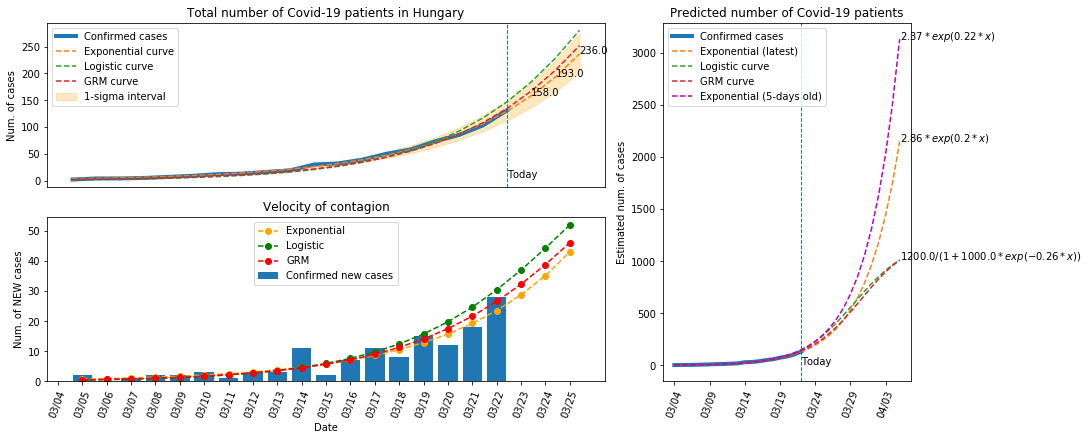

In [946]:
degrees = 70

fig = plt.figure(figsize=(15, 6),constrained_layout=True)
gs = fig.add_gridspec(2, 9)

ax1= fig.add_subplot(gs[:, 5:9])
ax1.plot(observed_dates,df['Total'],linewidth=4,label='Confirmed cases')
ax1.plot(long_all_dates,long_y_fit_exp,'--',label='Exponential (latest)')
ax1.plot(long_all_dates,long_y_fit_logit,'--',label='Logistic curve')
ax1.plot(long_all_dates,long_y_fit_GRM,'--',label='GRM curve')
ax1.plot(long_all_dates,long_y_fit_exp_old ,'m--',label='Exponential (5-days old)')

ax1.set_xticks(ax1.get_xticks()[::5])
ax1.set_xticklabels(long_all_dates[::5],rotation=degrees)

ax1.legend(loc='best')

ax1.axvline(long_all_dates[-long_extrapol_horizon-1],linestyle='dashed',linewidth=1,label='Today')
ax1.annotate('Today',xy=(long_all_dates[-long_extrapol_horizon-1],5))
ax1.set(ylabel='Estimated num. of cases')
ax1.set(title='Predicted number of Covid-19 patients')

#for i,j in zip(long_all_dates[-1:],long_y_fit_exp[-1:]):
#    ax1.annotate(str(round(j)),xy=(i,j))

ax1.annotate('${}*exp({}*x)$'.format(round(parameters_exp[0],2),round(parameters_exp[1],2)),xy=(long_all_dates[-1:],long_y_fit_exp[-1:]))
ax1.annotate('${}*exp({}*x)$'.format(round(parameters_exp_old[0],2),round(parameters_exp_old[1],2)),xy=(long_all_dates[-1:],long_y_fit_exp_old[-1:]))
ax1.annotate('${}/(1+{} * exp(-{}*x))$'.format(round(parameters_logit[0],2),round(parameters_logit[1],2),round(parameters_logit[2],2)),xy=(long_all_dates[-1:],long_y_fit_logit[-1:]))


#ax1.set_yscale('log')


#--------------------

ax2 = fig.add_subplot(gs[0, 0:5])
ax2.plot(observed_dates,df['Total'],linewidth=4,label='Confirmed cases')
ax2.get_xaxis().set_ticks([])

ax2.set(ylabel='Num. of cases')
ax2.set(title='Total number of Covid-19 patients in Hungary')


ax2.plot(all_dates,y_fit_exp,'--',label='Exponential curve')
ax2.plot(all_dates,y_fit_logit,'--',label='Logistic curve')
ax2.plot(all_dates,y_fit_GRM,'--',label='GRM curve')

for i,j in zip(all_dates[-extrapol_horizon:],y_fit_exp[-extrapol_horizon:]):
    ax2.annotate(str(round(j)),xy=(i,j))

ax2.fill_between(all_dates, fit_up, fit_dw, alpha=.25, label='1-sigma interval',color='orange')
#ax2.set_yscale('log')
ax2.legend(loc='best')

ax2.axvline(all_dates[-extrapol_horizon-1],linestyle='dashed',linewidth=1,label='Today')
ax2.annotate('Today',xy=(all_dates[-extrapol_horizon-1],5))

#ax2.annotate('${}*exp({}*x)$'.format(round(parameters_exp[0],2),round(parameters_exp[1],2)),xy=(all_dates[-4],fit_dw[-4]))

#--------------------

ax3 = fig.add_subplot(gs[1, 0:5])
ax3.bar(all_dates,np.concatenate((df['Total'].diff(), np.full(len(all_dates)-len(observed_dates), 0)), axis=0),label='Confirmed new cases')
ax3.plot(all_dates,np.concatenate(([np.nan],np.diff(y_fit_exp))),'--',color='orange',marker='o',label='Exponential')
ax3.plot(all_dates,np.concatenate(([np.nan],np.diff(y_fit_logit))),'g--',marker='o',label='Logistic')
ax3.plot(all_dates,np.concatenate(([np.nan],np.diff(y_fit_GRM))),'r--',marker='o',label='GRM')


ax3.set(xlabel='Date')
ax3.set(ylabel='Num. of NEW cases')
ax3.set(title='Velocity of contagion')
ax3.set_xticklabels(all_dates,rotation=degrees)

ax3.legend(loc='best')



In [641]:
df['Total'].to_numpy()[0]

2